In [1]:
#导入相应的包
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import torchvision
from torch.utils.data import DataLoader
from datetime import datetime  # 用于计算时间

import os
import sys
from collections import Counter
import re

#import tensorflow.contrib.keras as kr
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

from torchtext import data
import jieba

import cv2
import os

from torch.autograd import Variable
import tensorwatch as tw
import torchvision.models

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
torch.set_printoptions(precision=15)

## 路径

In [2]:
video_path = 'C:/Users/wuxun/Desktop/Data/feat_dat/'
image_path = 'C:/Users/wuxun/Desktop/Data/image/'#存储到image文件夹中
clip_path = 'C:/Users/wuxun/Desktop/Data/clip/'
text_dir = 'C:/Users/wuxun/Desktop/Data/clear_text.txt'
vocab_dir = 'C:/Users/wuxun/Desktop/Data/vocab.txt'
train_path = 'C:/Users/wuxun/Desktop/Data/training/training.txt'
val_path = 'C:/Users/wuxun/Desktop/Data/validation/validation.txt'
csv_path = 'D:/csv/'
save_path = 'C:/Users/wuxun/Desktop/Data/save_model/params.pkl'
save_path2 = 'C:/Users/wuxun/Desktop/Data/save_model2/params.pkl'

## 参数定义

In [3]:
#固定随机数种子
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

## 数据处理

In [5]:
 def read_file(filename):

    """读取文件数据"""
    
    contents = []
    with open(filename) as f:
        for line in f:
            contents.append(re.split('[, \n.]',line))
    return contents

In [6]:
def build_vocab(text_dir, vocab_dir, vocab_size=3000):

    """根据训练集构建词汇表，存储"""
    data_train = read_file(text_dir)
    all_data = []
    for content in data_train:
        for k in content:
            if len(k)!=0:
                all_data.append(k)
    print(all_data)
    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    open(vocab_dir, mode='w').write('\n'.join(words) + '\n')

In [7]:
def read_vocab(vocab_dir):

    """读取词汇表"""

    with open(vocab_dir) as fp:
        words = [(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [8]:
def to_words(content, words):

    """将id表示的内容转换为文字"""

    return ''.join(words[x] for x in content)

In [72]:
def get_dict(path, csv_path):
    '''
    获得最终的数据集
    path:文本数据集
    csv_path
    '''
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    source_csv=[]
    target_csv=[]
    fake_time_list=[]
    source_time_list=[]
    target_time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            source = List[4]
            target = List[5]
            fake_time = (List[7].split('_'))
            fake_time_l=int(fake_time[0])
            fake_time_r=int(fake_time[1])
            fake_time_list.append([fake_time_l, fake_time_r])
            
            #将句子转换为id表示：
            sentence = List[6].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点
            source = source.split('_')
            target = target.split('_')
            
            source_time = (float(source[0])+float(source[1]))//2
            source_time_list.append([float(source[0]),float(source[1])])
            source_frame_num = int(source_time/time_length*500)
            source_frame = frame_sum.loc[source_frame_num]
            source_csv.append([source_frame])
            
            target_time = (float(target[0])+float(target[1]))//2
            target_time_list.append([float(target[0]),float(target[1])])
            target_frame_num = int(target_time/time_length*500)
            target_frame = frame_sum.loc[target_frame_num]
            target_csv.append([target_frame])
            
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)
            
    print(len(batch_seq),len(source_csv),len(target_csv))
    
    return batch_seq, source_csv, target_csv, source_time_list, target_time_list

## 读取数据

In [73]:
#训练集
x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train = get_dict(train_path, csv_path)

1548 1548 1548


In [74]:
#验证集
x_batch_val, x_csv_val, y_csv_val, source_list_val, target_list_val = get_dict(val_path, csv_path)

523 523 523


## 模型定义

In [75]:
batch_size = 32
lamba = 0.2

In [76]:
# 定义LSTM的结构
class LSTM_CNN(nn.Module):
    
    def __init__(self):
        super(LSTM_CNN, self).__init__()
        
        self.embedding = nn.Embedding(5000, 64)
        self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        #self.rnn = nn.GRU(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.f1 = nn.Sequential(nn.Linear(256,128),
                                nn.Dropout(0.8),
                                nn.ReLU())

        self.f2 = nn.Sequential(nn.Linear(128,64))
        
        
        self.conv1=torch.nn.Sequential(
            torch.nn.Conv1d(1,10,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
        )
        
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv1d(10,20,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
        )

        #self.fc1=torch.nn.Linear(2520,128)
        self.fc1=torch.nn.Linear(512,128)
        self.fc1_drop=torch.nn.Dropout(p=0.4)
        self.fc2=torch.nn.Linear(128, 64)
        #self.fc2_drop=torch.nn.Dropout(p=0.4)
        #self.fc3=torch.nn.Linear(50,10)
        
        #特征融合
        self.final_fc = nn.Linear(in_features=128, out_features=64)
        self.score_fc = torch.nn.Conv2d(64,3,kernel_size=1,stride=1)
        
        
    def cnnout(self, x2):
        in_fc=x2.view(x2.size(0),-1)
        out_fc1=self.fc1(in_fc)
        out_drop=self.fc1_drop(out_fc1)
        out_fc2=self.fc2(out_drop)
        return out_fc2
        
    def forward(self, x1, x2): 
        if x1.shape[0]!=2:
            #lstm
            x = self.embedding(x1)
            x,_ = self.rnn(x)
            x = F.dropout(x,p=0.8)
            x = self.f1(x[:,-1,:])
            lstm_output = self.f2(x)

            #cnn
            cnn_out=self.cnnout(x2)
            #concat
            output = torch.cat((lstm_output, cnn_out), 1)
            output = self.final_fc(output)
            return output
        else:
            cnn_out=self.cnnout(x2)
            return cnn_out

In [77]:
model = LSTM_CNN()
T=Variable(torch.FloatTensor([[1.0,1.0],[1.0,1.0]]))
x1 = Variable(torch.LongTensor(x_batch_train[:32]))
x2 = Variable(torch.FloatTensor(x_csv_train[:32]))
out = model(T, x2)
print(out)

tensor([[-0.125699043273926,  0.208170861005783,  0.165499106049538,
          ...,  0.269221395254135, -0.027263864874840,
         -0.453361988067627],
        [-0.267356455326080, -0.179654389619827, -0.219347909092903,
          ...,  0.261154115200043,  0.135896682739258,
         -0.524131953716278],
        [ 0.205250397324562,  0.023807473480701, -0.093045689165592,
          ..., -0.079641662538052,  0.219029158353806,
         -0.382924199104309],
        ...,
        [-0.056071020662785,  0.259795725345612,  0.132375314831734,
          ...,  0.129218161106110,  0.152507871389389,
         -0.209005787968636],
        [ 0.002225100994110, -0.028226807713509, -0.167661815881729,
          ...,  0.344607472419739,  0.010264240205288,
         -0.270291686058044],
        [ 0.125593304634094,  0.107458181679249, -0.094442844390869,
          ...,  0.013903625309467,  0.194097697734833,
         -0.503260493278503]], grad_fn=<AddmmBackward>)


In [78]:
def batch_iter(x_batch, x_csv, y_csv, source_list, target_list, batch_size=32):

    """
    生成批次数据
    """

    data_len = x_batch.shape[0]
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.permutation(np.arange(data_len))
    x_batch_shuffle = x_batch[indices]
    x_csv_shuffle =np.array(x_csv)[indices]
    y_csv_shuffle = np.array(y_csv)[indices]
    source_list = np.array(source_list)[indices]
    target_list = np.array(target_list)[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_batch_shuffle[start_id:end_id], x_csv_shuffle[start_id:end_id], y_csv_shuffle[start_id:end_id], source_list[start_id:end_id], target_list[start_id:end_id]

In [80]:
#存储loss数据
train_loss_list = []
val_loss_list = []

In [81]:
def train():
    model = LSTM_CNN()
    Loss = torch.nn.TripletMarginLoss(margin=1.0, p=2)
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    T=Variable(torch.FloatTensor([[1.0,1.0],[1.0,1.0]]))
    best_val_loss = 1000000
    print("train begin......")

    for epoch in range(50):
        batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size)
        print("====================  epoch:"+str(epoch)+"  ========================")
        train_loss_sum = 0
        train_loss_avg = 0
        count = 0
        for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
            if x_csv.shape[0]==batch_size:
                x1 = torch.LongTensor(x_batch)
                x2 = np.array(x_csv)
                x2 = torch.FloatTensor(x2)
                y = np.array(y_csv)
                y = torch.FloatTensor(y)
                x1 = Variable(x1)
                x2 = Variable(x2)
                y = Variable(y)
                pred_y = model(x1, x2)
                negtive = model(T, x2)
                postive = model(T, y)
                loss_reg = Loss(pred_y, postive, negtive)
                train_loss_sum +=loss_reg
                optimizer.zero_grad()
                loss_reg.backward()
                #nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)#梯度裁剪
                optimizer.step()
                
        train_loss_avg = train_loss_sum //count
        print(str(train_loss_avg)+'***'+str(count))
        train_loss_list.append(train_loss_avg)

        #对模型进行验证：
        if (epoch+1)%5 == 0:
            print("进行验证.....")
            count = 0
            val_loss_sum = 0
            val_loss_avg = 0
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size)
            for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
                if x_csv.shape[0]==batch_size:
                    x1 = torch.LongTensor(x_batch)
                    x2 = np.array(x_csv)
                    x2 = torch.FloatTensor(x2)
                    y = np.array(y_csv)
                    y = torch.FloatTensor(y)
                    x1 = Variable(x1)
                    x2 = Variable(x2)
                    y = Variable(y)
                    pred_y = model(x1, x2)
                    negtive = model(T, x2)
                    postive = model(T, y)
                    loss_reg = Loss(pred_y, postive, negtive)
                    val_loss_sum +=loss_reg
                    optimizer.zero_grad()
                    loss_reg.backward()
                    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)#梯度裁剪
                    optimizer.step()
                    
            val_loss_avg = val_loss_sum //count
            print(val_loss_avg)
            val_loss_list.append(val_loss_avg)        
            if val_loss_avg < best_val_loss:
                torch.save(model.state_dict(), save_path)
                best_val_loss_2 = val_loss_avg
                print("model save!")

#### 训练模型

In [18]:
train()

train begin......
====================  epoch:0  ========================
tensor(1.005346059799194, grad_fn=<MeanBackward1>)
tensor(1.087628126144409, grad_fn=<MeanBackward1>)
tensor(0.908085107803345, grad_fn=<MeanBackward1>)
tensor(0.986273288726807, grad_fn=<MeanBackward1>)
tensor(1.096997857093811, grad_fn=<MeanBackward1>)
tensor(0.923112392425537, grad_fn=<MeanBackward1>)
tensor(0.916923463344574, grad_fn=<MeanBackward1>)
tensor(1.075593709945679, grad_fn=<MeanBackward1>)
tensor(0.775409281253815, grad_fn=<MeanBackward1>)
tensor(1.122478842735291, grad_fn=<MeanBackward1>)
tensor(0.943478584289551, grad_fn=<MeanBackward1>)
tensor(0.807927548885345, grad_fn=<MeanBackward1>)
tensor(1.196212410926819, grad_fn=<MeanBackward1>)
tensor(0.919873833656311, grad_fn=<MeanBackward1>)
tensor(0.959958136081696, grad_fn=<MeanBackward1>)
tensor(1.026795744895935, grad_fn=<MeanBackward1>)
tensor(0.935287475585938, grad_fn=<MeanBackward1>)
tensor(0.984789431095123, grad_fn=<MeanBackward1>)
tensor(0

tensor(0.385934382677078, grad_fn=<MeanBackward1>)
tensor(0.449105530977249, grad_fn=<MeanBackward1>)
tensor(0.488606244325638, grad_fn=<MeanBackward1>)
tensor(0.109466224908829, grad_fn=<MeanBackward1>)
tensor(0.197995081543922, grad_fn=<MeanBackward1>)
tensor(0.456337958574295, grad_fn=<MeanBackward1>)
tensor(0.387147039175034, grad_fn=<MeanBackward1>)
tensor(0.480540633201599, grad_fn=<MeanBackward1>)
tensor(0.321970343589783, grad_fn=<MeanBackward1>)
tensor(0.300217390060425, grad_fn=<MeanBackward1>)
tensor(0.569059073925018, grad_fn=<MeanBackward1>)
tensor(0.658274829387665, grad_fn=<MeanBackward1>)
tensor(0.425223827362061, grad_fn=<MeanBackward1>)
tensor(0.496686100959778, grad_fn=<MeanBackward1>)
tensor(0.315725207328796, grad_fn=<MeanBackward1>)
tensor(0.364386796951294, grad_fn=<MeanBackward1>)
tensor(0.332236766815186, grad_fn=<MeanBackward1>)
tensor(0.555460453033447, grad_fn=<MeanBackward1>)
tensor(0.419176012277603, grad_fn=<MeanBackward1>)
tensor(0.333458036184311, grad_

tensor(0.069458514451981, grad_fn=<MeanBackward1>)
tensor(0.173931747674942, grad_fn=<MeanBackward1>)
tensor(0.260328292846680, grad_fn=<MeanBackward1>)
tensor(0.207194447517395, grad_fn=<MeanBackward1>)
tensor(0.171728581190109, grad_fn=<MeanBackward1>)
tensor(0.340829372406006, grad_fn=<MeanBackward1>)
tensor(0.129030257463455, grad_fn=<MeanBackward1>)
tensor(0.149109050631523, grad_fn=<MeanBackward1>)
tensor(0.153390645980835, grad_fn=<MeanBackward1>)
tensor(0.243813902139664, grad_fn=<MeanBackward1>)
tensor(0.299996674060822, grad_fn=<MeanBackward1>)
tensor(0.159101217985153, grad_fn=<MeanBackward1>)
tensor(0.407702893018723, grad_fn=<MeanBackward1>)
tensor(0.294063329696655, grad_fn=<MeanBackward1>)
tensor(0.237786978483200, grad_fn=<MeanBackward1>)
tensor(0.407059013843536, grad_fn=<MeanBackward1>)
tensor(0.420112162828445, grad_fn=<MeanBackward1>)
tensor(0.166182890534401, grad_fn=<MeanBackward1>)
tensor(0.371247321367264, grad_fn=<MeanBackward1>)
tensor(0.296201020479202, grad_

tensor(0.092166602611542, grad_fn=<MeanBackward1>)
tensor(0.109856531023979, grad_fn=<MeanBackward1>)
tensor(0.300921648740768, grad_fn=<MeanBackward1>)
tensor(0.111603707075119, grad_fn=<MeanBackward1>)
tensor(0.145087867975235, grad_fn=<MeanBackward1>)
tensor(0.304744720458984, grad_fn=<MeanBackward1>)
tensor(0.101564988493919, grad_fn=<MeanBackward1>)
tensor(0.225746601819992, grad_fn=<MeanBackward1>)
tensor(0.182644337415695, grad_fn=<MeanBackward1>)
tensor(0.123940348625183, grad_fn=<MeanBackward1>)
tensor(0.119728505611420, grad_fn=<MeanBackward1>)
tensor(0.034565806388855, grad_fn=<MeanBackward1>)
tensor(0.080366343259811, grad_fn=<MeanBackward1>)
tensor(0.212059050798416, grad_fn=<MeanBackward1>)
tensor(0.038466483354568, grad_fn=<MeanBackward1>)
tensor(0.258536517620087, grad_fn=<MeanBackward1>)
tensor(0.209271162748337, grad_fn=<MeanBackward1>)
tensor(0.001428395509720, grad_fn=<MeanBackward1>)
tensor(0.210338264703751, grad_fn=<MeanBackward1>)
tensor(0.153596520423889, grad_

tensor(0.191340625286102, grad_fn=<MeanBackward1>)
tensor(0.030113816261292, grad_fn=<MeanBackward1>)
tensor(0.163359910249710, grad_fn=<MeanBackward1>)
tensor(0.256733655929565, grad_fn=<MeanBackward1>)
tensor(0.063277006149292, grad_fn=<MeanBackward1>)
tensor(0.104289054870605, grad_fn=<MeanBackward1>)
tensor(0.111854612827301, grad_fn=<MeanBackward1>)
tensor(0.029627501964569, grad_fn=<MeanBackward1>)
tensor(0.134380340576172, grad_fn=<MeanBackward1>)
tensor(0.226036041975021, grad_fn=<MeanBackward1>)
tensor(0.085134536027908, grad_fn=<MeanBackward1>)
tensor(0.090478479862213, grad_fn=<MeanBackward1>)
进行验证.....
tensor(0.504432439804077, grad_fn=<MeanBackward1>)
tensor(0.288662135601044, grad_fn=<MeanBackward1>)
tensor(0.388662576675415, grad_fn=<MeanBackward1>)
tensor(0.474804610013962, grad_fn=<MeanBackward1>)
tensor(0.105843842029572, grad_fn=<MeanBackward1>)
model save!
tensor(0.251119971275330, grad_fn=<MeanBackward1>)
tensor(0.200237512588501, grad_fn=<MeanBackward1>)
tensor(0.

tensor(0.041500687599182, grad_fn=<MeanBackward1>)
tensor(0.222034096717834, grad_fn=<MeanBackward1>)
tensor(0.096188366413116, grad_fn=<MeanBackward1>)
tensor(0.127591490745544, grad_fn=<MeanBackward1>)
tensor(0.262072145938873, grad_fn=<MeanBackward1>)
tensor(0.034387469291687, grad_fn=<MeanBackward1>)
tensor(0.140857994556427, grad_fn=<MeanBackward1>)
tensor(0.078769087791443, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.103708088397980, grad_fn=<MeanBackward1>)
tensor(0.088412880897522, grad_fn=<MeanBackward1>)
tensor(0.037810087203979, grad_fn=<MeanBackward1>)
tensor(0.197956264019012, grad_fn=<MeanBackward1>)
tensor(0.162426829338074, grad_fn=<MeanBackward1>)
tensor(0.208102405071259, grad_fn=<MeanBackward1>)
tensor(0.226125717163086, grad_fn=<MeanBackward1>)
tensor(0.067275583744049, grad_fn=<MeanBackward1>)
tensor(0.012258112430573, grad_fn=<MeanBackward1>)
====================  epoch:31  ========================
tensor(0.107621550559998, grad_fn=<MeanB

tensor(0., grad_fn=<MeanBackward1>)
====================  epoch:37  ========================
tensor(0.077527284622192, grad_fn=<MeanBackward1>)
tensor(0.089160799980164, grad_fn=<MeanBackward1>)
tensor(0.001226902008057, grad_fn=<MeanBackward1>)
tensor(0.011585772037506, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.080505341291428, grad_fn=<MeanBackward1>)
tensor(0.025765478610992, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.041876792907715, grad_fn=<MeanBackward1>)
tensor(0.223126649856567, grad_fn=<MeanBackward1>)
tensor(0.066027700901031, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.056789815425873, grad_fn=<MeanBackward1>)
tensor(0.139987587928772, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.128927767276764, grad_fn=<MeanBackward1>)
tensor(0.047122955322266, grad_fn=<MeanBackward1>)
tensor(0.202178537845612, gr

tensor(0.080463111400604, grad_fn=<MeanBackward1>)
tensor(0.155738890171051, grad_fn=<MeanBackward1>)
tensor(0.110471844673157, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.059432744979858, grad_fn=<MeanBackward1>)
tensor(0.197504281997681, grad_fn=<MeanBackward1>)
tensor(0.074363112449646, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.091332107782364, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.092254400253296, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.005615472793579, grad_fn=<MeanBackward1>)
tensor(0.130796551704407, grad_fn=<MeanBackward1>)
tensor(0.084783554077148, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.276646614074707, grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0., grad_fn=<MeanBackward1>)
tensor(0.122185528278351, grad_fn=<MeanBackward1>)
tensor(0.080083489418030, grad_fn=<MeanBackward1>)
tensor(0.062303185462952, grad_fn=

tensor(0.119139313697815, grad_fn=<MeanBackward1>)
tensor(0.093063712120056, grad_fn=<MeanBackward1>)
tensor(0.062203884124756, grad_fn=<MeanBackward1>)
进行验证.....
tensor(0.362783014774323, grad_fn=<MeanBackward1>)
tensor(0.428422689437866, grad_fn=<MeanBackward1>)
tensor(0.080245912075043, grad_fn=<MeanBackward1>)
tensor(0.363866686820984, grad_fn=<MeanBackward1>)
tensor(0.082422912120819, grad_fn=<MeanBackward1>)
tensor(0.422504335641861, grad_fn=<MeanBackward1>)
tensor(0.286839604377747, grad_fn=<MeanBackward1>)
tensor(0.421518623828888, grad_fn=<MeanBackward1>)
tensor(0.463650763034821, grad_fn=<MeanBackward1>)
tensor(0.290082216262817, grad_fn=<MeanBackward1>)
tensor(0.177631139755249, grad_fn=<MeanBackward1>)
tensor(0.007412552833557, grad_fn=<MeanBackward1>)
model save!
tensor(0.125959396362305, grad_fn=<MeanBackward1>)
tensor(0.169672161340714, grad_fn=<MeanBackward1>)
tensor(0.158914804458618, grad_fn=<MeanBackward1>)
tensor(0.353431463241577, grad_fn=<MeanBackward1>)


#### 绘制Loss曲线

In [ ]:
def draw(train_loss_list, val_loss_list):
    x1 = range(0, len(train_loss_list))
    x2 = range(0, len(val_loss_list))
    plt.subplot(2, 1, 1)
    plt.plot(x1, train_loss_list[:len(train_loss_list)], 'o-')
    plt.title('train loss vs. epoches')
    plt.ylabel('train loss')
    plt.subplot(2, 1, 2)
    plt.plot(x2,val_loss_list[:len(val_loss_list)] , '.-')
    plt.xlabel('Val loss vs. epoches')
    plt.ylabel('Val loss')
    plt.show()

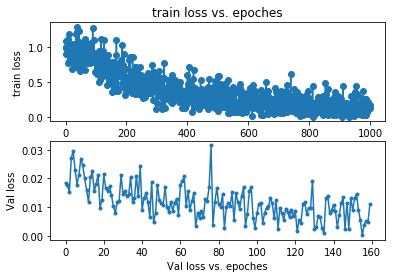

In [22]:
draw(train_loss_list, val_loss_list)

### 加载模型

In [82]:
model = LSTM_CNN()
model.load_state_dict(torch.load(save_path))

### 创建回归模型

##### 回归模型定义

In [83]:
# 定义LSTM的结构
class Change(nn.Module):
    
    def __init__(self):
        super(Change, self).__init__()
        #特征融合
        self.score_fc = torch.nn.Conv2d(64,3,kernel_size=1,stride=1)
        
    def forward(self, x):
        output = x
        #特征转换
        output_expand = output.expand([batch_size, batch_size, 64])
        output_expand = output_expand.unsqueeze(0).permute(0,3,1,2)
        score = self.score_fc(output_expand).squeeze(0)

        alignment_mat = score[0]
        l_mat = score[1]
        r_mat = score[2]
        
        I = torch.eye(batch_size)
        allone = torch.ones(batch_size, batch_size)
        mask = allone-2*I

        l_reg = torch.mm(l_mat*I, torch.ones(batch_size,1))
        r_reg = torch.mm(r_mat*I, torch.ones(batch_size,1))
        offset_pred = torch.cat([l_reg, r_reg],1)
        return offset_pred

In [84]:
change_model = Change() 

In [86]:
train_loss_2_list=[]
val_loss_2_list=[]

In [87]:
def train_2():
    change_model = Change()
    Loss = torch.nn.L1Loss()
    optimizer = optim.Adam(change_model.parameters(), lr = 0.001)
    best_val_loss_2 = 1000000
    print("train begin......")
 
    for epoch in range(200):
        batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size)
        print("====================  epoch:"+str(epoch)+"  ========================")
        train_loss_sum = 0
        train_loss_avg = 0
        for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
            if x_csv.shape[0]==batch_size:
                count += 1
                x1 = Variable(torch.LongTensor(x_batch))
                x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                source_time = Variable(torch.FloatTensor(np.array(source_time)))
                target_time = Variable(torch.FloatTensor(np.array(target_time)))
                pred = model(x1, x2)
                pred2 = change_model(pred)
                loss_reg = Loss(pred2, target_time)
                train_loss_sum +=loss_reg
                optimizer.zero_grad()
                loss_reg.backward()
                optimizer.step()
                
        train_loss_avg = train_loss_sum //count
        print(str(train_loss_avg)+'***'+str(count))
        train_loss_2_list.append(train_loss_avg)
        
        if (epoch+1)%5==0:
            print("进行验证.......")
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size)
            count = 0
            val_loss_sum = 0
            val_loss_avg = 0 
            for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
                if x_csv.shape[0]==batch_size:
                    count += 1
                    x1 = Variable(torch.LongTensor(x_batch))
                    x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                    source_time = Variable(torch.FloatTensor(np.array(source_time)))
                    target_time = Variable(torch.FloatTensor(np.array(target_time)))
                    pred = model(x1, x2)
                    pred2 = change_model(pred)
                    loss_reg = Loss(pred2, target_time)
                    val_loss_sum +=loss_reg
                    optimizer.zero_grad()
                    loss_reg.backward()
                    optimizer.step()
                    
            val_loss_avg = val_loss_sum //count
            print(val_loss_avg)
            val_loss_2_list.append(val_loss_avg)        
            if val_loss_avg < best_val_loss_2:
                torch.save(change_model.state_dict(), save_path2)
                best_val_loss_2 = val_loss_avg
                print("model save!")
            

#### 训练回归模型

In [88]:
train_2()

train begin......
====================  epoch:0  ========================
tensor(188., grad_fn=<TruncBackward>)***48
====================  epoch:1  ========================
tensor(183., grad_fn=<TruncBackward>)***48
====================  epoch:2  ========================
tensor(179., grad_fn=<TruncBackward>)***48
====================  epoch:3  ========================
tensor(174., grad_fn=<TruncBackward>)***48
====================  epoch:4  ========================
tensor(170., grad_fn=<TruncBackward>)***48
进行验证.......
tensor(159., grad_fn=<TruncBackward>)
model save!
====================  epoch:5  ========================
tensor(165., grad_fn=<TruncBackward>)***48
====================  epoch:6  ========================
tensor(162., grad_fn=<TruncBackward>)***48
====================  epoch:7  ========================
tensor(158., grad_fn=<TruncBackward>)***48
====================  epoch:8  ========================
tensor(155., grad_fn=<TruncBackward>)***48
====================  epoch:9

====================  epoch:73  ========================
tensor(115., grad_fn=<TruncBackward>)***48
====================  epoch:74  ========================
tensor(113., grad_fn=<TruncBackward>)***48
进行验证.......
tensor(104., grad_fn=<TruncBackward>)
model save!
====================  epoch:75  ========================
tensor(114., grad_fn=<TruncBackward>)***48
====================  epoch:76  ========================
tensor(113., grad_fn=<TruncBackward>)***48
====================  epoch:77  ========================
tensor(113., grad_fn=<TruncBackward>)***48
====================  epoch:78  ========================
tensor(112., grad_fn=<TruncBackward>)***48
====================  epoch:79  ========================
tensor(113., grad_fn=<TruncBackward>)***48
进行验证.......
tensor(105., grad_fn=<TruncBackward>)
====================  epoch:80  ========================
tensor(112., grad_fn=<TruncBackward>)***48
====================  epoch:81  ========================
tensor(114., grad_fn=<TruncBack

====================  epoch:146  ========================
tensor(104., grad_fn=<TruncBackward>)***48
====================  epoch:147  ========================
tensor(102., grad_fn=<TruncBackward>)***48
====================  epoch:148  ========================
tensor(102., grad_fn=<TruncBackward>)***48
====================  epoch:149  ========================
tensor(104., grad_fn=<TruncBackward>)***48
进行验证.......
tensor(98., grad_fn=<TruncBackward>)
====================  epoch:150  ========================
tensor(102., grad_fn=<TruncBackward>)***48
====================  epoch:151  ========================
tensor(103., grad_fn=<TruncBackward>)***48
====================  epoch:152  ========================
tensor(104., grad_fn=<TruncBackward>)***48
====================  epoch:153  ========================
tensor(103., grad_fn=<TruncBackward>)***48
====================  epoch:154  ========================
tensor(104., grad_fn=<TruncBackward>)***48
进行验证.......
tensor(96., grad_fn=<TruncBack

#### 绘制loss

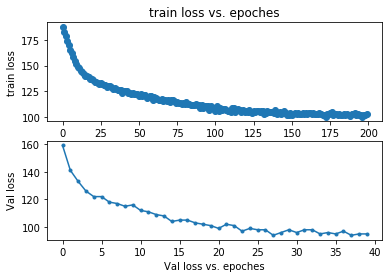

In [90]:
draw(train_loss_2_list, val_loss_2_list)

### 计算R@1

In [94]:
def calculate_IoU(i0,i1):
    union = (min(i0[0], i1[0]), max(i0[1], i1[1]))
    inter = (max(i0[0], i1[0]), min(i0[1], i1[1]))
    iou = 1.0*(inter[1]-inter[0])/(union[1]-union[0])
    return iou

In [ ]:
'''
compute recall at certain IoU
'''
def compute_IoU_recall_top_n_forreg(top_n, iou_thresh, sentence_image_mat, sentence_image_reg_mat, sclips, iclips):
    correct_num = 0.0
    for k in range(sentence_image_mat.shape[0]):
        gt = sclips[k]
        gt_start = float(gt.split("_")[1])
        gt_end = float(gt.split("_")[2])
        print gt +" "+str(gt_start)+" "+str(gt_end)
        sim_v = [v for v in sentence_image_mat[k]]
        starts = [s for s in sentence_image_reg_mat[k,:,0]]
        ends = [e for e in sentence_image_reg_mat[k,:,1]]
        picks = nms_temporal(starts,ends, sim_v, iou_thresh-0.05)
        #sim_argsort=np.argsort(sim_v)[::-1][0:top_n]
        if top_n<len(picks): picks=picks[0:top_n]
        for index in picks:
            pred_start = sentence_image_reg_mat[k, index, 0]
            pred_end = sentence_image_reg_mat[k, index, 1]
            iou = calculate_IoU((gt_start, gt_end),(pred_start, pred_end))
            if iou>=iou_thresh:
                correct_num+=1
                break
    return correct_num